In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd
import time
from sklearn.metrics import r2_score
import rrcf

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())

In [3]:
def partial_train(mtr, X_test, y_test):
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    mtr.partial_fit(X_test, y_test)
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std

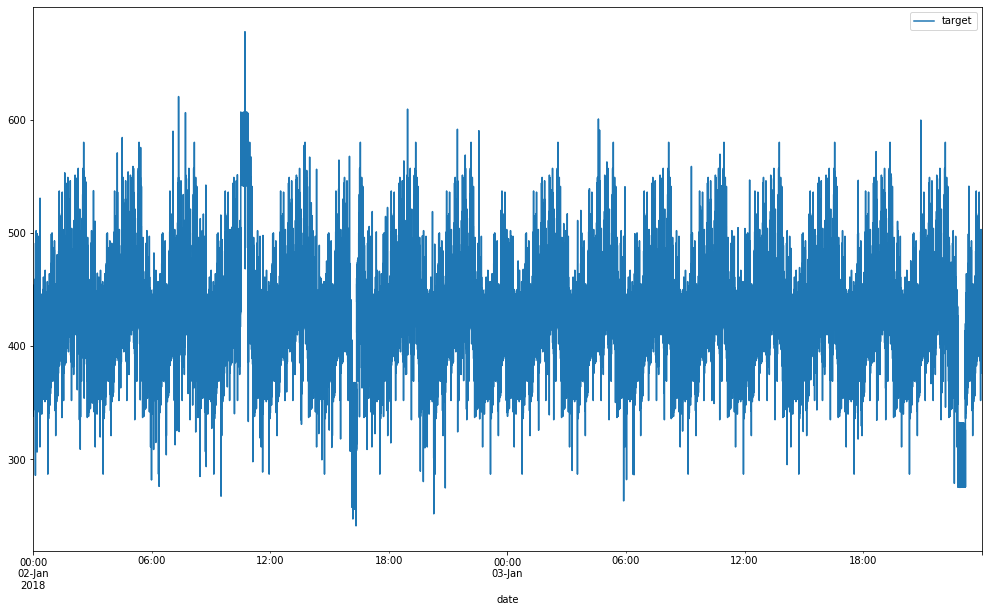

In [4]:
network = pd.read_csv('./intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

rcParams['figure.figsize'] = 17,10
network.describe()
network.plot()

In [5]:
#construct forest of empty RCTrees

num_trees = 40
shingle_size = 60
tree_size = 256


forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

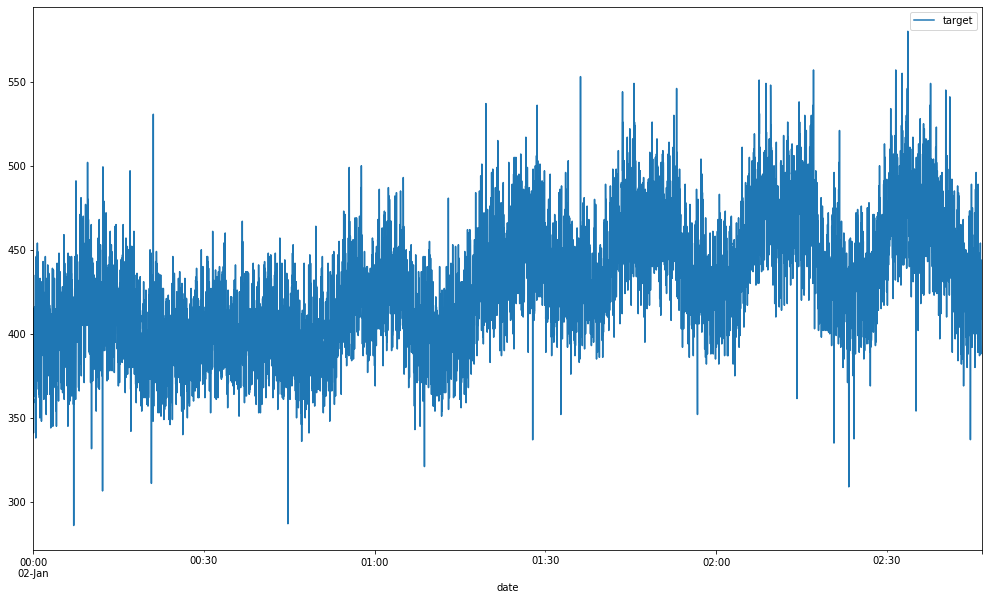

In [6]:
#train data 정제
ntw_clean = network.copy()

train_len = 10000
ntw_clean = ntw_clean[:train_len]

avg_codisp = {}
train_mean = ntw_clean.mean()

ntw_clean.plot()

In [7]:
for index in range(0, train_len) :
    point = ntw_clean[index:index+1] #get one by one
    
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        
        ntw_clean.iloc[index] = train_mean
        


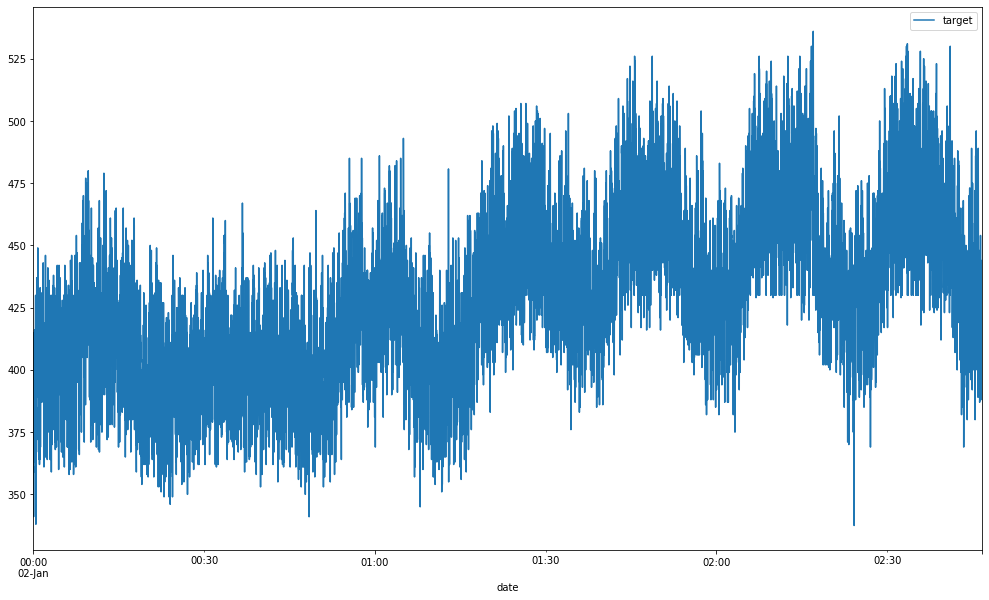

In [8]:

ntw_clean.plot()


In [9]:
avg_codisp

{0: 0.0,
 1: 1.0000000000000004,
 2: 1.0000000000000004,
 3: 2.2499999999999996,
 4: 1.2874999999999994,
 5: 1.3124999999999998,
 6: 1.2875000000000003,
 7: 2.7250000000000005,
 8: 4.425000000000001,
 9: 2.712500000000001,
 10: 1.125,
 11: 3.3166666666666678,
 12: 2.862499999999998,
 13: 2.0375,
 14: 3.4791666666666674,
 15: 1.8020833333333324,
 16: 1.785416666666667,
 17: 1.8604166666666662,
 18: 3.273333333333332,
 19: 2.6624999999999996,
 20: 2.81,
 21: 2.620833333333333,
 22: 2.147023809523809,
 23: 2.6268749999999996,
 24: 10.437499999999996,
 25: 2.50125,
 26: 2.2565909090909098,
 27: 9.17791666666667,
 28: 1.393333333333333,
 29: 2.029166666666667,
 30: 2.072765151515152,
 31: 5.662500000000001,
 32: 11.411458333333334,
 33: 2.859125457875458,
 34: 2.1658333333333335,
 35: 2.944860347985348,
 36: 6.203759920634919,
 37: 3.4844318181818177,
 38: 3.8197591460826756,
 39: 2.0325595238095246,
 40: 1.8859485570544012,
 41: 3.8704751498501513,
 42: 3.023396672771674,
 43: 2.2479166666

In [10]:
#train set만들기
tmp = ntw_clean.shift(1)
tmp2 = ntw_clean.shift(2)
tmp3 = ntw_clean.shift(3)

ntw_prev = ntw_clean.copy()
ntw_prev['prev1'] = tmp['target']
ntw_prev['prev2'] = tmp2['target']
ntw_prev['prev3'] = tmp3['target']

ntw_prev = ntw_prev[4:]
ntw_prev.tail()

,target,prev1,prev2,prev3
date,,,,
2018-01-02 02:46:35,409.0,416.0,437.0,443.0
2018-01-02 02:46:36,412.0,409.0,416.0,437.0
2018-01-02 02:46:37,418.0,412.0,409.0,416.0
2018-01-02 02:46:38,425.0,418.0,412.0,409.0
2018-01-02 02:46:39,442.0,425.0,418.0,412.0


In [11]:


#training은 clean한 data로, test는 clean하지 않은 data를 rrcf로 다시 정제하면서 진행할거임



#xt = [network[10000:10001], network.iloc[10001], network.iloc[10002]]
xt = pd.Series()


In [12]:
type(xt)
print(xt)

Series([], dtype: float64)


In [15]:
 def partial_fit(self, X, y, classes=None):
        """
        Incremental building of Mondrian Forests.
        Parameters
        ----------
        X : array_like, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32``
        y: array_like, shape = [n_samples]
            Input targets.
        classes: array_like, shape = [n_classes]
            Ignored for a regression problem. For a classification
            problem, if not provided this is inferred from y.
            This is taken into account for only the first call to
            partial_fit and ignored for subsequent calls.
        Returns
        -------
        self: instance of MondrianForest
        """
        X, y = check_X_y(X, y, dtype=np.float32, multi_output=False)
        random_state = check_random_state(self.random_state)

        # Wipe out estimators if partial_fit is called after fit.
        first_call = not hasattr(self, "first_")
        if first_call:
            self.first_ = True

        if isinstance(self, ClassifierMixin):
            if first_call:
                if classes is None:
                    classes = LabelEncoder().fit(y).classes_

                self.classes_ = classes
                self.n_classes_ = len(self.classes_)

        # Remap output
        n_samples, self.n_features_ = X.shape

        y = np.atleast_1d(y)
        if y.ndim == 2 and y.shape[1] == 1:
            warn("A column-vector y was passed when a 1d array was"
                 " expected. Please change the shape of y to "
                 "(n_samples,), for example using ravel().",
                 DataConversionWarning, stacklevel=2)

        self.n_outputs_ = 1

        # Initialize estimators at first call to partial_fit.
        if first_call:
            # Check estimators
            self._validate_estimator()
            self.estimators_ = []

            for _ in range(self.n_estimators):
                tree = self._make_estimator(append=False, random_state=random_state)
                self.estimators_.append(tree)

        # XXX: Switch to threading backend when GIL is released.
        if isinstance(self, ClassifierMixin):
            self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
                delayed(_single_tree_pfit)(t, X, y, classes) for t in self.estimators_)
        else:
            self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
                delayed(_single_tree_pfit)(t, X, y) for t in self.estimators_)

        return self

In [17]:
class MondrianForestRegressor(ForestRegressor, BaseMondrian):
    """
    A MondrianForestRegressor is an ensemble of MondrianTreeRegressors.
    The variance in predictions is reduced by averaging the predictions
    from all trees.
    Parameters
    ----------
    n_estimators : integer, optional (default=10)
        The number of trees in the forest.
    max_depth : integer, optional (default=None)
        The depth to which each tree is grown. If None, the tree is either
        grown to full depth or is constrained by `min_samples_split`.
    min_samples_split : integer, optional (default=2)
        Stop growing the tree if all the nodes have lesser than
        `min_samples_split` number of samples.
    bootstrap : boolean, optional (default=False)
        If bootstrap is set to False, then all trees are trained on the
        entire training dataset. Else, each tree is fit on n_samples
        drawn with replacement from the training dataset.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    """
    def __init__(self,
                 n_estimators=10,
                 max_depth=None,
                 min_samples_split=2,
                 bootstrap=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0):
        super(MondrianForestRegressor, self).__init__(
            base_estimator=MondrianTreeRegressor(),
            n_estimators=n_estimators,
            estimator_params=("max_depth", "min_samples_split",
                              "random_state"),
            bootstrap=bootstrap,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        """Builds a forest of trees from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] or [n_samples, n_outputs]
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, dtype=np.float32, multi_output=False)
        return super(MondrianForestRegressor, self).fit(X, y)

    def predict(self, X, return_std=False):
        """
        Returns the predicted mean and std.
        The prediction is a GMM drawn from
        \(\sum_{i=1}^T w_i N(m_i, \sigma_i)\) where \(w_i = {1 \over T}\).
        The mean \(E[Y | X]\) reduces to \({\sum_{i=1}^T m_i \over T}\)
        The variance \(Var[Y | X]\) is given by $$Var[Y | X] = E[Y^2 | X] - E[Y | X]^2$$
        $$=\\frac{\sum_{i=1}^T E[Y^2_i| X]}{T} - E[Y | X]^2$$
        $$= \\frac{\sum_{i=1}^T (Var[Y_i | X] + E[Y_i | X]^2)}{T} - E[Y| X]^2$$
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Input samples.
        return_std : boolean, default (False)
            Whether or not to return the standard deviation.
        Returns
        -------
        y : array-like, shape = (n_samples,)
            Predictions at X.
        std : array-like, shape = (n_samples,)
            Standard deviation at X.
        """
        X = check_array(X)
        if not hasattr(self, "estimators_"):
            raise NotFittedError("The model has to be fit before prediction.")
        ensemble_mean = np.zeros(X.shape[0])
        exp_y_sq = np.zeros_like(ensemble_mean)

        for est in self.estimators_:
            if return_std:
                mean, std = est.predict(X, return_std=True)
                exp_y_sq += (std**2 + mean**2)
            else:
                mean = est.predict(X, return_std=False)
            ensemble_mean += mean

        ensemble_mean /= len(self.estimators_)
        exp_y_sq /= len(self.estimators_)

        if not return_std:
            return ensemble_mean
        std = exp_y_sq - ensemble_mean**2
        std[std <= 0.0] = 0.0
        std **= 0.5
        return ensemble_mean, std

    def partial_fit(self, X, y):
        """
        Incremental building of Mondrian Forest Regressors.
        Parameters
        ----------
        X : array_like, shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32``
        y: array_like, shape = [n_samples]
            Input targets.
        classes: array_like, shape = [n_classes]
            Ignored for a regression problem. For a classification
            problem, if not provided this is inferred from y.
            This is taken into account for only the first call to
            partial_fit and ignored for subsequent calls.
        Returns
        -------
        self: instance of MondrianForestClassifier
        """
        return super(MondrianForestRegressor, self).partial_fit(X, y)


NameError: name 'ForestRegressor' is not defined

In [16]:
mfr = MondrianForestRegressor(random_state = 1, n_estimators=100, bootstrap=True)
for i in range(3, len(ntw_clean)):
    X_train = pd.Series()
    X_train['prev1'] = ntw_clean[i-3:i-2]['target']
    X_train['prev2'] = ntw_clean[i-2:i-1]['target']
    X_train['prev3'] = ntw_clean[i-1:i]['target']
    y_train = ntw_clean[i:i+1]['target']
    mfr.partial_fit(X_train.values.reshape(1, -1), y_train)

prediction = np.array([])
stdeviation = np.array([])

#일단 Test mean은 train mean과 같게 시작
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0



AttributeError: 'MondrianForestRegressor' object has no attribute 'partial_fit'

In [ ]:
cleaned = np.array([])
for tree in forest :
    print(tree.leaves.keys())

In [ ]:
for i in range(0, 50000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10004+i:10004+i+1]['target']
    xt['prev1'] = network[10001+i:10001+i+1]['target']
    xt['prev2'] = network[10002+i:10002+i+1]['target']
    xt['prev3'] = network[10003+i:10003+i+1]['target']

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000
    print(index)
    #yt의 anomaly여부 판단
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    print(z)
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        yt = test_sum/test_num
    
    cleaned = np.append(cleaned, [yt])
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt
    test_num += 1
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    
    

In [ ]:
len(prediction)
len(cleaned)

In [ ]:
plt.plot(network[10004:11004].index, prediction[:1000])


In [ ]:
plt.plot(network.index[10004:20004], cleaned[0:10000])
plt.plot(network[10004:20004])

In [ ]:
print(score_for_res(prediction, network[10004:20004]['target']))
print(score_for_res(prediction, cleaned))